Created By: Cameron Craig

This notebook contains my work exploring how to generate and apply Rician distributed noise to images. The notebook also contains some early work exploring how to generate smoothly varying bias fields, and how to do image correction with the antspy library.

In [ ]:
#@title Install Packages
!pip install python-gdcm
!pip install pydicom
!pip install antspyx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 3.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 319.4 MB 36 kB/s 
     |████████████████████████████████| 64 kB 3.1 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=619d997f63802c191f91f9bd3db5dac76771b26eb87b5fa78fd9b7a4b60f86d9
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
#@title Imports
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from PIL import Image as im, ImageOps
import pydicom
import ants
import cv2

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def normalize(image):
  new_image = image - np.min(image)
  return new_image / np.max(new_image)

In [ ]:
# Clip/clamp all values in numpy array to the range [0, 1]
def clip_img(image):
  image = np.where(image > 1, 1, image)
  return np.where(image < 0, 0, image)

In [ ]:
# Applies Rician noise to the input numpy array, with variable noise intensity
def add_rician_noise(image, intensity=1):
  n1 = np.random.normal(0, 1, image.shape)
  n1 = n1 / np.max(n1)
  n2 = np.random.normal(0, 1, image.shape)
  n2 = n2 / np.max(n2)
  return clip_img(np.abs(image + intensity*n1 + intensity*n2*1j))

In [ ]:
def show(image):
  display(im.fromarray(np.uint8(image * 255)))

In [ ]:
def save_as_img(np_array, filename):
  img = im.fromarray(np.uint8(cm.gray(normalize(np_array))*255))
  img.save(filename)

In [ ]:
# Knee MRI
path = r'/content/drive/MyDrive/Summer 2022/ECE 697/Project/knee_dicom_batch2/1FB_1001820591____1FB,_3331562518/study_2f43b031/MR4_53c76c27/00001_092a9e78cea34328.dcm'
ds = pydicom.dcmread(path)
ds.decompress('gdcm')
img = ds.pixel_array
img = normalize(img)

In [ ]:
# Circular Saw
#img = im.open('/content/drive/MyDrive/ECE697/data/tools/tools020.png')
img = im.open('/content/bucky_transparent.png')
img = img.resize((128, 128))
mask = np.asarray(img)[:,:,3]
img = ImageOps.grayscale(img)
img = np.asarray(img)
img = np.where(mask > 0, img, 0 )
img = normalize(img)

In [ ]:
# Arbitrary Image uploaded manually
img = Image.open('/content/brain_mri_clean.jpeg')
img = np.asarray(img)

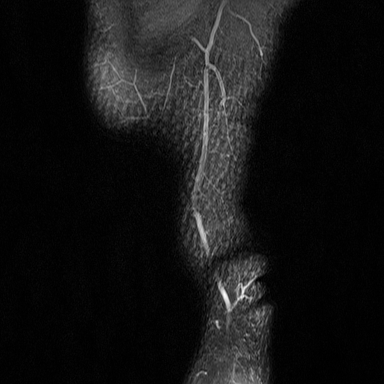

In [ ]:
show(img)

In [ ]:
img.shape

(384, 384)

In [ ]:
save_as_img(img, 'bucky_clean_input.png')

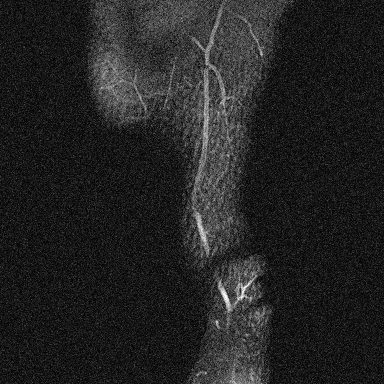

In [ ]:
show(add_rician_noise(img, 0.3))

In [ ]:
save_as_img(add_rician_noise(img, 0.2), 'bucky_slightly_noisy.png')

In [ ]:
img.shape

(128, 128)

In [ ]:
SIZE = img.shape[0]
x = np.linspace(-1, 1, num=SIZE)

In [ ]:
y_vert = (1 / (0.8 + np.exp(-3*x))) + 0.2
#y_vert = (y_vert / np.max(np.absolute(y_vert))) + 1


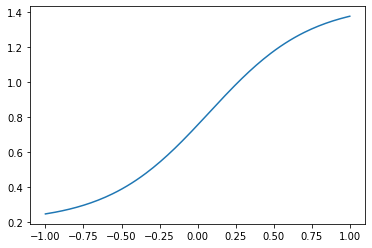

In [ ]:
plt.plot(x, y_vert)

In [ ]:
y_horiz = -(x**4)
y_horiz = (y_horiz / np.max(np.absolute(y_horiz))) + 1

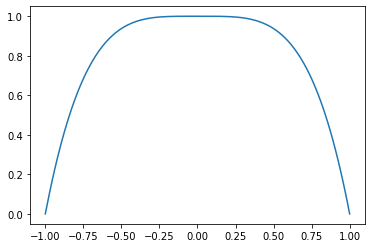

In [ ]:
plt.plot(x, y_horiz)

In [ ]:
np.reshape(y_vert, (-1, 1)).shape

(128, 1)

In [ ]:
vert_mask = (normalize(np.tile(np.reshape(y_vert, (-1, 1)), (1, SIZE))) * 0.95) + 0.05

In [ ]:
horiz_mask = normalize(np.tile(np.reshape(y_horiz, (1, -1)), (SIZE, 1)))

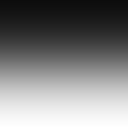

In [ ]:
show(vert_mask)

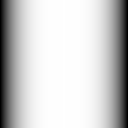

In [ ]:
show(horiz_mask)

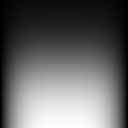

In [ ]:
#mask = (vert_mask + horiz_mask) / 2
mask = 4*vert_mask * horiz_mask
#mask = mask / np.max(mask)
mask = normalize(mask)
show(mask)

In [ ]:
save_as_img(mask, 'mask.png')

In [ ]:
np.max(mask)

1.0

In [ ]:
np.min(mask)

0.0

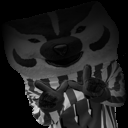

In [ ]:
show(np.multiply(img, mask))

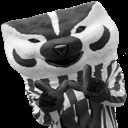

In [ ]:
show(img)

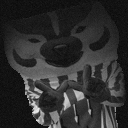

In [ ]:
sim_singlecoil = add_rician_noise(np.multiply(img, mask), 0.1)
show(sim_singlecoil)

In [ ]:
save_as_img(sim_singlecoil, 'bucky_sim_singlecoil.png')

In [ ]:
aimg = ants.from_numpy(circ_singlecoil)

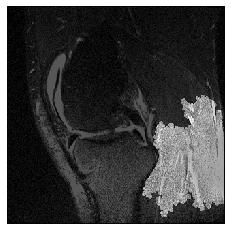

In [ ]:
corrected = ants.abp_n4(aimg, intensity_truncation=(0.025, 0.95, 256), usen3=False)
cimg = corrected.numpy()
show(cimg)